# TAOS2 - drifters1 campaign: OOD drifter prototype

[Description prototype](https://sites.google.com/view/oodprotov10-052023/premiers-essais)


In [1]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
import cmocean.cm as cm

import numpy as np
import pandas as pd
import xarray as xr
import hvplot.pandas  # noqa
#from scipy import integrate

#
import pynsitu as pin
from pynsitu.maps import crs
#import taos.sensors as se

In [2]:
## taos
root_dir = "/Users/aponte/Current_Projects/taos/campagnes/taos2/"

# taos2-drifters1
campaign="taos2_drifters1"
yaml = f"drifters1/{campaign}.yaml"

cp = pin.Campaign(os.path.join(root_dir,yaml))

# plot all deployments
for label, deployment, platform, sensor, meta in cp.get_all_deployments():
    print(label, platform, sensor, deployment)

day0 None None day0 / start 2023-06-12 14:00:00 / end 2023-06-12 19:00:00
day1 None None day1 / start 2023-06-13 07:50:00 / end 2023-06-13 15:30:00
day2 None None day2 / start 2023-06-15 05:50:00 / end 2023-06-15 09:35:00
d0 parceque None d0 / start 2023-06-12 15:48:00 / end 2023-06-12 18:59:00
d0 hydrophone None d0 / start 2023-06-12 14:10:00 / end 2023-06-12 18:48:00
c0 hydrophone ctd c0 / start 2023-06-12 17:24:57 -0.25 49.34 / end 2023-06-12 17:26:23 -0.25 49.34
c1 hydrophone ctd c1 / start 2023-06-12 17:29:30 -0.26 49.33 / end 2023-06-12 17:31:41 -0.26 49.33
c2 hydrophone ctd c2 / start 2023-06-12 17:37:00 -0.26 49.32 / end 2023-06-12 17:39:19 -0.26 49.32
c3 hydrophone ctd c3 / start 2023-06-12 17:44:30 -0.27 49.33 / end 2023-06-12 17:46:43 -0.27 49.33
c4 hydrophone ctd c4 / start 2023-06-12 17:51:35 -0.26 49.33 / end 2023-06-12 17:53:46 -0.26 49.33
c5 hydrophone ctd c5 / start 2023-06-12 18:00:47 -0.25 49.34 / end 2023-06-12 18:02:19 -0.25 49.34
c6 hydrophone ctd c6 / start 2023-

---

## load data


In [42]:
p = "ood_drifter"
d = "station"

df = pd.read_csv(os.path.join(cp["path_raw"], cp[p]["file"]))

df = df.rename(columns=dict(average_temperature="temperature", average_conductivity="conductivity"))

# adjust conductivity units
conductivity_scale = 1e-3 # uS/cm to mS/cm
df["conductivity"] = df["conductivity"] * conductivity_scale
df["conductivity_RMS"] = df["conductivity_RMS"] * conductivity_scale

# tmp, waiting adjustment of ood code
df = df.rename(columns=dict(temperature_RMS="temperature_square_mean", conductivity_RMS="conductivity_square_mean"))
df["temperature_rms"] = np.sqrt(df["temperature_square_mean"]**2 - df["temperature"]**2)
df["conductivity_rms"] = np.sqrt(df["conductivity_square_mean"]**2 - df["conductivity"]**2)

df["time"] = pd.to_datetime(df["time"])
df = df.set_index("time")

df["pressure"] = 1 # dbar


#df.sw.update_eos()
df.sw.init()

df.head()

some values of longitude and latitudes are NaN, you may want to fill in with correct values


,latitude,longitude,temperature,temperature_square_mean,conductivity,conductivity_square_mean,temperature_rms,conductivity_rms,pressure,depth,salinity,SA,CT,sigma0
time,,,,,,,,,,,,,,
2023-06-12 13:59:14,49.335960,-0.459695,25.533443,25.545959,0.0,0.0,0.799569,0.0,1,0.991486,NaN,NaN,NaN,NaN
2023-06-12 14:05:33,49.336079,-0.459010,24.554111,24.562830,0.0,0.0,0.654389,0.0,1,0.991486,0.0,0.0,25.816224,-2.838345
2023-06-12 14:11:52,49.336166,-0.458517,24.423347,24.444990,0.0,0.0,1.028417,0.0,1,0.991486,NaN,NaN,NaN,NaN
2023-06-12 14:18:12,49.339859,-0.451439,21.291075,21.315607,0.0,0.0,1.022370,0.0,1,0.991486,0.0,0.0,22.397536,-2.067513
2023-06-12 14:24:30,49.342716,-0.385226,17.093884,17.097235,0.0,0.0,0.338499,0.0,1,0.991486,0.0,0.0,17.997633,-1.237841


In [ ]:
_df = df.sort_index()
_df.geo.compute_velocities(inplace=True)
_df.geo.plot_bokeh(deployments=cp[p][d], velocity=True, acceleration=True)

In [47]:
# split into different deployments and store
D = {}
for label, d in cp[p]["deployments"].items():
    print(label, d)
    _df = df.ts.trim(d)
    _df.to_xarray().to_netcdf(os.path.join(cp["path_processed"], p+"_"+label+".nc"), mode="w")
    D[label] = _df

station station / start 2023-06-12 16:45:00 / end 2023-06-12 18:20:00
drift drift / start 2023-06-12 18:50:00 / end 2023-06-14 03:05:00


Text(0, 0.5, 'conductivity')

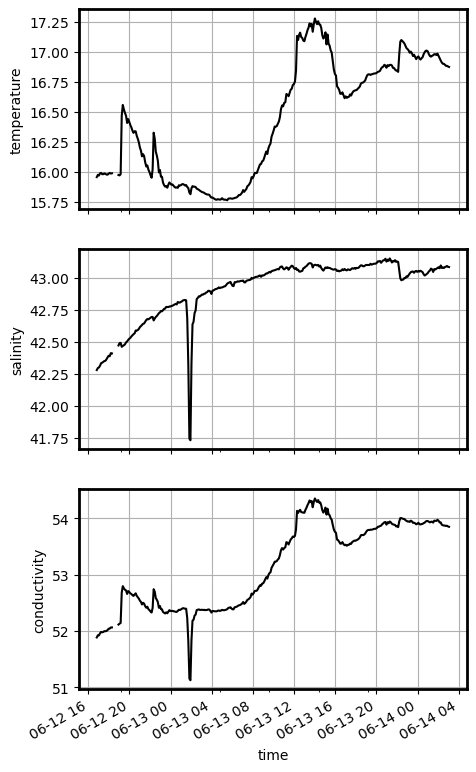

In [44]:
fig, axes = plt.subplots(3,1, figsize=(5,10), sharex=True)

ax = axes[0]
for label, d in cp[p]["deployments"].items():
    D[label]["temperature"].plot(ax=ax, color="k")
ax.grid()
ax.set_ylabel("temperature")

ax = axes[1]
for label, d in cp[p]["deployments"].items():
    D[label]["salinity"].plot(ax=ax, color="k")
ax.grid()
ax.set_ylabel("salinity")

ax = axes[2]
for label, d in cp[p]["deployments"].items():
    D[label]["conductivity"].plot(ax=ax, color="k")
ax.grid()
ax.set_ylabel("conductivity")

Text(0, 0.5, 'conductivity_rms')

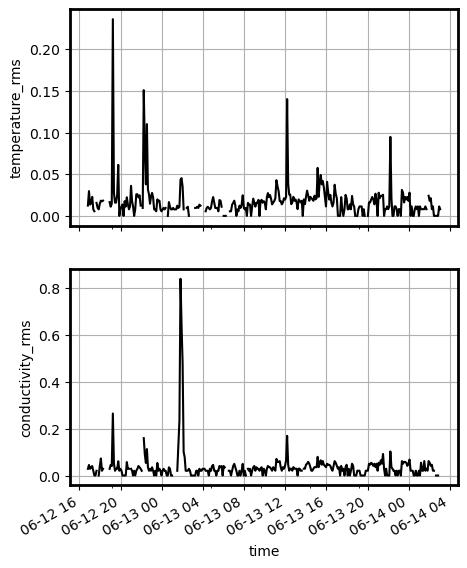

In [45]:
fig, axes = plt.subplots(2,1, figsize=(5,7), sharex=True)

ax = axes[0]
for label, d in cp[p]["deployments"].items():
    D[label]["temperature_rms"].plot(ax=ax, color="k")
ax.grid()
ax.set_ylabel("temperature_rms")

ax = axes[1]
for label, d in cp[p]["deployments"].items():
    D[label]["conductivity_rms"].plot(ax=ax, color="k")
ax.grid()
ax.set_ylabel("conductivity_rms")